<font size="6"><b>Random Forest</b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

# Data Loading 

In [2]:
dfm = pd.read_csv('dfm.csv', index_col=0)
dfm.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,15.0,3,3,10.0,3,-23.0,268.0,250.0,225.0,1605.0,1,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,11.0,2,3,7.0,3,-24.0,99.0,83.0,65.0,414.0,1,1,0,0
2,United Airlines,Santa Ana,Denver,3,-5.0,15.0,3,3,5.0,3,-13.0,134.0,126.0,106.0,846.0,1,1,0,0
3,United Airlines,Ft. Myers,Chicago,3,6.0,19.0,3,3,6.0,3,-2.0,190.0,182.0,157.0,1120.0,1,1,0,0
6,United Airlines,Houston,Las Vegas,2,-3.0,14.0,2,2,6.0,2,-16.0,206.0,193.0,173.0,1222.0,1,1,0,0


In [3]:
dfm.CRS_DEP_TIME.value_counts(normalize=True)

2    0.384188
3    0.365040
4    0.180800
1    0.069971
Name: CRS_DEP_TIME, dtype: float64

In [4]:
dfm.CRS_ARR_TIME.value_counts(normalize=True)

3    0.351728
2    0.314401
4    0.307390
1    0.026481
Name: CRS_ARR_TIME, dtype: float64

In [5]:
dfm.WEEKDAY.value_counts(normalize=True)

0    0.150752
4    0.149194
3    0.148208
2    0.145112
1    0.143837
6    0.141355
5    0.121542
Name: WEEKDAY, dtype: float64

In [6]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   OP_CARRIER           object 
 1   ORIGIN               object 
 2   DEST                 object 
 3   CRS_DEP_TIME         int64  
 4   DEP_DELAY            float64
 5   TAXI_OUT             float64
 6   WHEELS_OFF           int64  
 7   WHEELS_ON            int64  
 8   TAXI_IN              float64
 9   CRS_ARR_TIME         int64  
 10  ARR_DELAY            float64
 11  CRS_ELAPSED_TIME     float64
 12  ACTUAL_ELAPSED_TIME  float64
 13  AIR_TIME             float64
 14  DISTANCE             float64
 15  DAY                  int64  
 16  MONTH                int64  
 17  FLIGHT_STATUS        int64  
 18  WEEKDAY              int64  
dtypes: float64(8), int64(8), object(3)
memory usage: 607.6+ MB


In [7]:
dfm.shape

(3982067, 19)

In [8]:
dfm.isna().sum()

OP_CARRIER             0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_DELAY              0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
DAY                    0
MONTH                  0
FLIGHT_STATUS          0
WEEKDAY                0
dtype: int64

# Data Distribution

In [9]:
def scaling_check(data):
    
    case_count = dfm['FLIGHT_STATUS'].value_counts() 
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=case_count.index, y=case_count.values)
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.title('Data Distribution', fontsize=16)
    plt.xlabel('Flight Status', fontsize=12)
    plt.ylabel('Number of Flights', fontsize=12)
    plt.xticks(range(len(case_count.index)), ['ON TIME(0)', 'DELAYED(1)'])
    plt.show()

Legend:
0    2503954
1    1478113
Name: FLIGHT_STATUS, dtype: int64


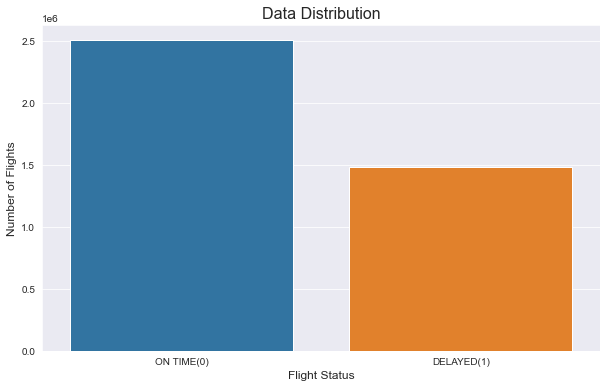

In [10]:
scaling_check(dfm)

In [11]:
dfm.FLIGHT_STATUS.value_counts(normalize=True)

0    0.628808
1    0.371192
Name: FLIGHT_STATUS, dtype: float64

In [13]:
dfm.head(2)

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,15.0,3,3,10.0,3,-23.0,268.0,250.0,225.0,1605.0,1,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,11.0,2,3,7.0,3,-24.0,99.0,83.0,65.0,414.0,1,1,0,0


In [14]:
dfm.FLIGHT_STATUS.value_counts()

0    2503954
1    1478113
Name: FLIGHT_STATUS, dtype: int64

In [41]:
count_0 = 2503954
count_1 = 1478113

In [42]:
print(count_0)
print(count_1)

2503954
1478113


In [43]:
initial_bias = np.log([count_1/count_0])
initial_bias

weight_for_0 = (1/count_0)*(count_0 + count_1)/2.0
weight_for_1 = (1/count_1)*(count_0 + count_1)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.80
Weight for class 1: 1.35


In [19]:
dfm.DEP_DELAY.value_counts(normalize=True)

-5.0       7.629304e-02
-4.0       7.321298e-02
-3.0       7.112336e-02
-6.0       6.491955e-02
-2.0       6.459962e-02
               ...     
 1271.0    2.511259e-07
 1445.0    2.511259e-07
 1458.0    2.511259e-07
 1394.0    2.511259e-07
 1307.0    2.511259e-07
Name: DEP_DELAY, Length: 1431, dtype: float64

In [20]:
dfm_test=dfm[(dfm['DEP_DELAY'] > 1000)]
dfm_test

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
7521,SkyWest Airlines,Eau Claire,Chicago,1,1041.0,18.0,4,4,7.0,2,1032.0,82.0,73.0,48.0,269.0,1,1,1,0
8227,SkyWest Airlines,Atlanta,Chicago,3,1140.0,26.0,2,2,13.0,3,1144.0,130.0,134.0,95.0,606.0,1,1,1,0
14275,American Airlines,Eagle,Dallas-Fort Worth,3,1144.0,17.0,2,3,14.0,4,1135.0,133.0,124.0,93.0,721.0,1,1,1,0
14636,American Airlines,Detroit,Dallas-Fort Worth,3,1013.0,34.0,2,2,8.0,4,1001.0,189.0,177.0,135.0,986.0,1,1,1,0
21972,Spirit Airlines,Detroit,Denver,3,1332.0,48.0,3,3,9.0,4,1345.0,202.0,215.0,158.0,1123.0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202763,United Airlines,Eagle,Newark,3,1306.0,18.0,2,3,8.0,4,1271.0,241.0,206.0,180.0,1725.0,31,12,1,0
7203678,Endeavor Air,Traverse City,Detroit,3,1231.0,21.0,3,3,12.0,4,1226.0,78.0,73.0,40.0,207.0,31,12,1,0
7211246,SkyWest Airlines,Minneapolis,Houston,4,1074.0,20.0,3,3,10.0,4,1068.0,192.0,186.0,156.0,1034.0,31,12,1,0
7212368,SkyWest Airlines,Aspen,San Francisco,4,1041.0,29.0,3,3,8.0,4,1026.0,156.0,141.0,104.0,848.0,31,12,1,0


# Categoricals

In [21]:
dfm.columns

Index(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_DELAY',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'DAY', 'MONTH', 'FLIGHT_STATUS', 'WEEKDAY'],
      dtype='object')

In [23]:
OP_CARRIER_dummies = pd.get_dummies(dfm['OP_CARRIER'], prefix='OP_CARRIER', drop_first=True)
DEST_dummies = pd.get_dummies(dfm['DEST'], prefix='DEST', drop_first=True)
CRS_DEP_TIME_dummies = pd.get_dummies(dfm['CRS_DEP_TIME'], prefix='CRS_DEP_TIME', drop_first=True)
CRS_ARR_TIME_dummines = pd.get_dummies(dfm['CRS_ARR_TIME'], prefix='CRS_ARR_TIME', drop_first=True) 
MONTH_dummies = pd.get_dummies(dfm['MONTH'], prefix='MONTH', drop_first=True)
WEEKDAY_dummies = pd.get_dummies(dfm['WEEKDAY'], prefix='WEEKDAY', drop_first=True)


In [24]:
dfm = dfm.drop(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY', 'ACTUAL_ELAPSED_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'ARR_DELAY', 'TAXI_IN', 'TAXI_OUT'], axis=1)

In [25]:
dfm = pd.concat([dfm, OP_CARRIER_dummies, DEST_dummies, CRS_DEP_TIME_dummies, CRS_ARR_TIME_dummines, MONTH_dummies, WEEKDAY_dummies], axis=1)

In [26]:
dfm.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,99.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
dfm.shape

(3982067, 65)

In [10]:
dfm.to_csv('dfm_ready.csv')

# Random Forest

In [28]:
# Create features (X) and labels (y)
y = dfm['FLIGHT_STATUS']
X = dfm.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

In [29]:
# data split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
# Build a regular tree 
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [31]:
tree_clf.feature_importances_

array([0.09442743, 0.04933339, 0.00145623, 0.00182833, 0.        ,
       0.        , 0.15623902, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06195038, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06183805, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13748605, 0.01904133, 0.        , 0.        ,
       0.3559772 , 0.        , 0.        , 0.        , 0.        ,
       0.00447347, 0.00566442, 0.        , 0.        , 0.        ,
       0.00645226, 0.        , 0.        , 0.        , 0.00697834,
       0.00093831, 0.03591579, 0.        ])

<b>Model Performance</b>

In [33]:
# Test set predictions
pred = tree_clf.predict(X_test)

In [34]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1788059,89938,1877997
1,992044,116509,1108553
All,2780103,206447,2986550


In [35]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.64      0.95      0.77   1877997
           1       0.56      0.11      0.18   1108553

    accuracy                           0.64   2986550
   macro avg       0.60      0.53      0.47   2986550
weighted avg       0.61      0.64      0.55   2986550



In [37]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 63.77%


In [38]:
# RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [39]:
# checking the accuracy score
forest.score(X_train, y_train)

0.6291786076983116

In [40]:
# And for the test set:
forest.score(X_test, y_test)

0.629185515059182

<b>MODEL PERFORMANCE</b>

In [54]:
# Test set predictions
pred_rf = forest.predict(X_test)

In [55]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1889305,103,1889408
1,1116169,615,1116784
All,3005474,718,3006192


In [56]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rf))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.77   1889408
           1       0.86      0.00      0.00   1116784

    accuracy                           0.63   3006192
   macro avg       0.74      0.50      0.39   3006192
weighted avg       0.71      0.63      0.49   3006192



In [58]:
print("Testing Accuracy for RandomForest Classifier: {:.4}%".format(accuracy_score(y_test, pred_rf) * 100))

Testing Accuracy for RandomForest Classifier: 62.87%
